# vanilla VAE

In [116]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
        # Mean and variance layers
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )
        
    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_var(h)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, log_var = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

def loss_function(recon_x, x, mu, log_var):
    # Reconstruction loss (binary cross entropy)
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    
    # KL divergence loss
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    return BCE + KLD

def train_vae(model, train_loader, optimizer, device, epoch):
    model.train()
    train_loss = 0
    
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = model(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
    
    avg_loss = train_loss / len(train_loader.dataset)
    print(f'====> Epoch: {epoch} Average loss: {avg_loss:.4f}')
    return avg_loss

def visualize_reconstruction(model, data_loader, device, num_images=8):
    model.eval()
    with torch.no_grad():
        data = next(iter(data_loader))[0][:num_images].to(device)
        recon_batch, _, _ = model(data)
        
        # Plot original and reconstructed images
        fig, axes = plt.subplots(2, num_images, figsize=(2*num_images, 4))
        
        for i in range(num_images):
            # Original images
            axes[0, i].imshow(data[i].cpu().numpy().reshape(28, 28), cmap='gray')
            axes[0, i].axis('off')
            if i == 0:
                axes[0, i].set_title('Original')
                
            # Reconstructed images
            axes[1, i].imshow(recon_batch[i].cpu().numpy().reshape(28, 28), cmap='gray')
            axes[1, i].axis('off')
            if i == 0:
                axes[1, i].set_title('Reconstructed')
        
        plt.tight_layout()
        return fig

# Training setup and example usage
def main():
    # Hyperparameters
    batch_size = 128
    epochs = 50
    learning_rate = 1e-3
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load MNIST dataset
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize model, optimizer
    model = VAE().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training loop
    for epoch in range(1, epochs + 1):
        loss = train_vae(model, train_loader, optimizer, device, epoch)
        
        # Visualize reconstructions every 10 epochs
        if epoch % 10 == 0:
            fig = visualize_reconstruction(model, train_loader, device)
            plt.close(fig)  # Close the figure to free memory
    
    return model

if __name__ == "__main__":
    model = main()

Train Epoch: 1 [0/60000 (0%)]	Loss: 545.436523
Train Epoch: 1 [12800/60000 (21%)]	Loss: 196.406570
Train Epoch: 1 [25600/60000 (43%)]	Loss: 181.622375
Train Epoch: 1 [38400/60000 (64%)]	Loss: 152.583252
Train Epoch: 1 [51200/60000 (85%)]	Loss: 139.749771
====> Epoch: 1 Average loss: 177.9475
Train Epoch: 2 [0/60000 (0%)]	Loss: 138.321274
Train Epoch: 2 [12800/60000 (21%)]	Loss: 134.720749
Train Epoch: 2 [25600/60000 (43%)]	Loss: 130.118225
Train Epoch: 2 [38400/60000 (64%)]	Loss: 125.180267
Train Epoch: 2 [51200/60000 (85%)]	Loss: 124.887672
====> Epoch: 2 Average loss: 127.4434
Train Epoch: 3 [0/60000 (0%)]	Loss: 114.934959
Train Epoch: 3 [12800/60000 (21%)]	Loss: 122.640129
Train Epoch: 3 [25600/60000 (43%)]	Loss: 115.139252
Train Epoch: 3 [38400/60000 (64%)]	Loss: 117.428596
Train Epoch: 3 [51200/60000 (85%)]	Loss: 116.499481
====> Epoch: 3 Average loss: 117.5079
Train Epoch: 4 [0/60000 (0%)]	Loss: 120.244354
Train Epoch: 4 [12800/60000 (21%)]	Loss: 106.897842
Train Epoch: 4 [25600/

KeyboardInterrupt: 

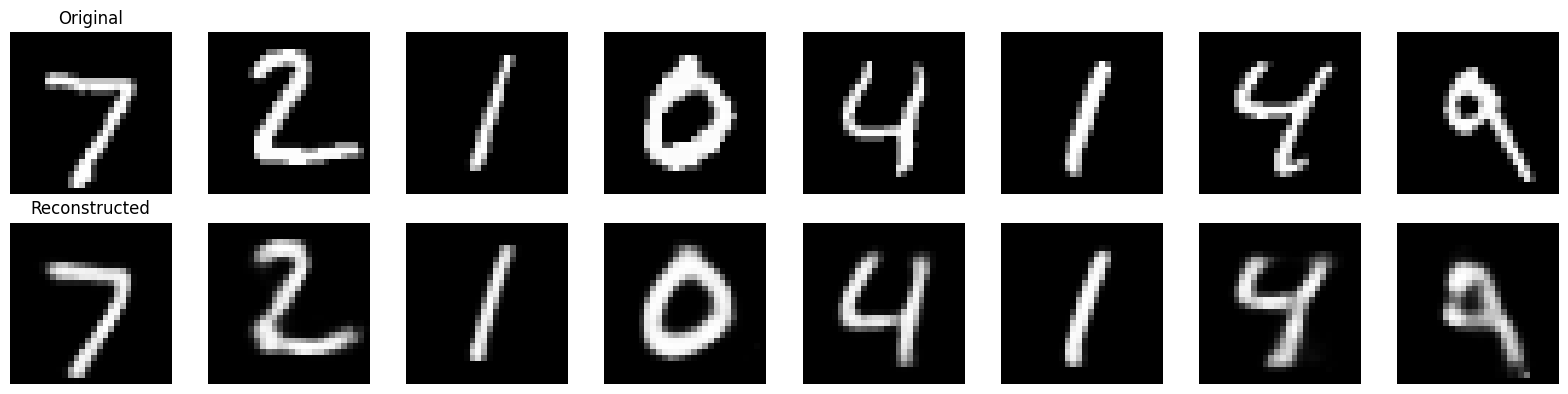

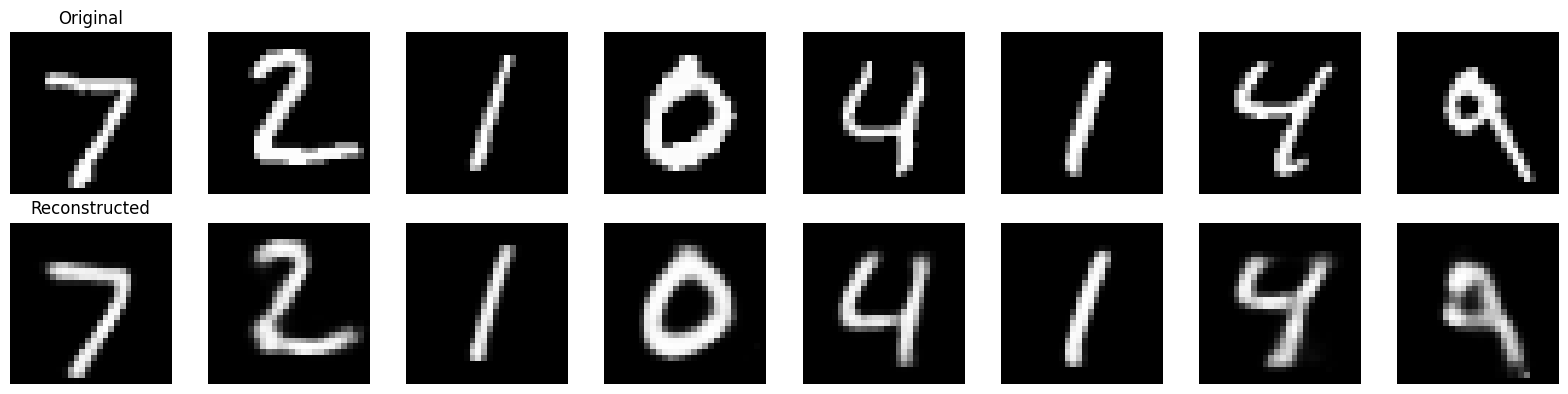

In [3]:
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor()
])

test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

visualize_reconstruction(model, test_loader, 'cpu')

In [81]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

class ConditionalVAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20, condition_dim=10):
        super(ConditionalVAE, self).__init__()
        
        self.condition_dim = condition_dim
        self.input_with_condition = input_dim + condition_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(self.input_with_condition, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
        # Mean and variance layers
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + condition_dim, hidden_dim),  # Note: decoder input includes condition
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )
        
    def encode(self, x, c):
        # Concatenate input and condition
        x_c = torch.cat([x, c], dim=1)
        h = self.encoder(x_c)
        return self.fc_mu(h), self.fc_var(h)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z, c):
        # Concatenate latent vector and condition
        z_c = torch.cat([z, c], dim=1)
        return self.decoder(z_c)
    
    def forward(self, x, c):
        mu, log_var = self.encode(x.view(-1, 784), c)
        z = self.reparameterize(mu, log_var)
        return self.decode(z, c), mu, log_var

def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

def train_conditional_vae(model, train_loader, optimizer, device, epoch):
    model.train()
    train_loss = 0
    
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        
        # Convert labels to one-hot encoding
        c = F.one_hot(labels, num_classes=model.condition_dim).float().to(device)
        
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(data, c)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
    
    avg_loss = train_loss / len(train_loader.dataset)
    print(f'====> Epoch: {epoch} Average loss: {avg_loss:.4f}')
    return avg_loss

def visualize_conditional_reconstruction(model, data_loader, device, target_label=None, num_images=8):
    model.eval()
    with torch.no_grad():
        # Get a batch of images
        for data, labels in data_loader:
            if target_label is not None:
                # Filter images of target label
                mask = labels == target_label
                if mask.sum() >= num_images:
                    data = data[mask][:num_images]
                    labels = labels[mask][:num_images]
                    break
            else:
                data = data[:num_images]
                labels = labels[:num_images]
                break
        
        data = data.to(device)
        c = F.one_hot(labels, num_classes=model.condition_dim).float().to(device)
        
        # Get reconstructions
        recon_batch, _, _ = model(data, c)
        
        # Plot original and reconstructed images
        fig, axes = plt.subplots(2, num_images, figsize=(2*num_images, 4))
        
        for i in range(num_images):
            # Original images
            axes[0, i].imshow(data[i].cpu().numpy().reshape(28, 28), cmap='gray')
            axes[0, i].axis('off')
            if i == 0:
                axes[0, i].set_title(f'Original (Label: {labels[i].item()})')
            
            # Reconstructed images
            axes[1, i].imshow(recon_batch[i].cpu().numpy().reshape(28, 28), cmap='gray')
            axes[1, i].axis('off')
            if i == 0:
                axes[1, i].set_title('Reconstructed')
        
        plt.tight_layout()
        return fig

def generate_conditioned_samples(model, device, condition, num_samples=8):
    model.eval()
    with torch.no_grad():
        # Create one-hot encoded condition
        c = F.one_hot(torch.tensor([condition] * num_samples), 
                     num_classes=model.condition_dim).float().to(device)
        
        # Sample from latent space
        z = torch.randn(num_samples, model.fc_mu.out_features).to(device)
        
        # Generate samples
        samples = model.decode(z, c)
        
        # Visualize
        fig, axes = plt.subplots(1, num_samples, figsize=(2*num_samples, 2))
        for i in range(num_samples):
            axes[i].imshow(samples[i].cpu().numpy().reshape(28, 28), cmap='gray')
            axes[i].axis('off')
            if i == 0:
                axes[i].set_title(f'Generated (Label: {condition})')
        
        plt.tight_layout()
        return fig

def main():
    # Hyperparameters
    batch_size = 128
    epochs = 5
    learning_rate = 1e-3
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load MNIST dataset
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize model, optimizer
    model = ConditionalVAE(condition_dim=10).to(device)  # 10 classes for MNIST
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training loop
    for epoch in range(1, epochs + 1):
        loss = train_conditional_vae(model, train_loader, optimizer, device, epoch)
        
        # Visualize reconstructions every 10 epochs
        if epoch % 10 == 0:
            # Visualize general reconstructions
            fig1 = visualize_conditional_reconstruction(model, train_loader, device)
            plt.close(fig1)
            
            # Visualize generated samples for a specific digit
            fig2 = generate_conditioned_samples(model, device, condition=7)  # Generate digit 7
            plt.close(fig2)
    
    return model

if __name__ == "__main__":
    model = main()

Train Epoch: 1 [0/60000 (0%)]	Loss: 543.504517
Train Epoch: 1 [12800/60000 (21%)]	Loss: 198.536484
Train Epoch: 1 [25600/60000 (43%)]	Loss: 155.062271
Train Epoch: 1 [38400/60000 (64%)]	Loss: 145.275208
Train Epoch: 1 [51200/60000 (85%)]	Loss: 142.151550
====> Epoch: 1 Average loss: 167.7229
Train Epoch: 2 [0/60000 (0%)]	Loss: 129.791229
Train Epoch: 2 [12800/60000 (21%)]	Loss: 125.729263
Train Epoch: 2 [25600/60000 (43%)]	Loss: 123.110619
Train Epoch: 2 [38400/60000 (64%)]	Loss: 120.193649
Train Epoch: 2 [51200/60000 (85%)]	Loss: 117.099136
====> Epoch: 2 Average loss: 123.0143
Train Epoch: 3 [0/60000 (0%)]	Loss: 112.631104
Train Epoch: 3 [12800/60000 (21%)]	Loss: 115.049080
Train Epoch: 3 [25600/60000 (43%)]	Loss: 117.202835
Train Epoch: 3 [38400/60000 (64%)]	Loss: 116.039612
Train Epoch: 3 [51200/60000 (85%)]	Loss: 110.768692
====> Epoch: 3 Average loss: 113.7051
Train Epoch: 4 [0/60000 (0%)]	Loss: 106.070862
Train Epoch: 4 [12800/60000 (21%)]	Loss: 115.185242
Train Epoch: 4 [25600/

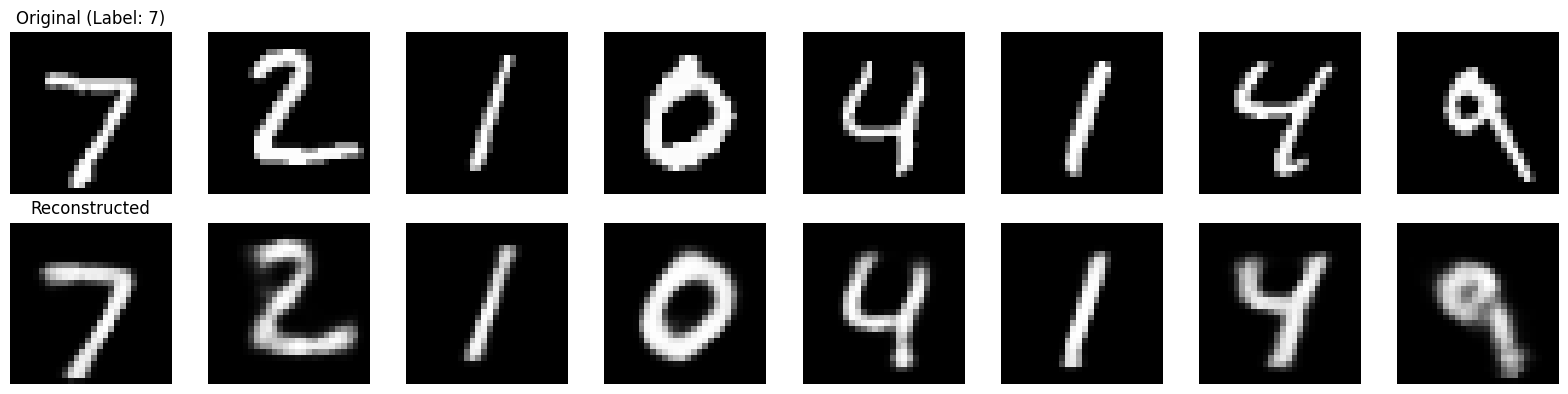

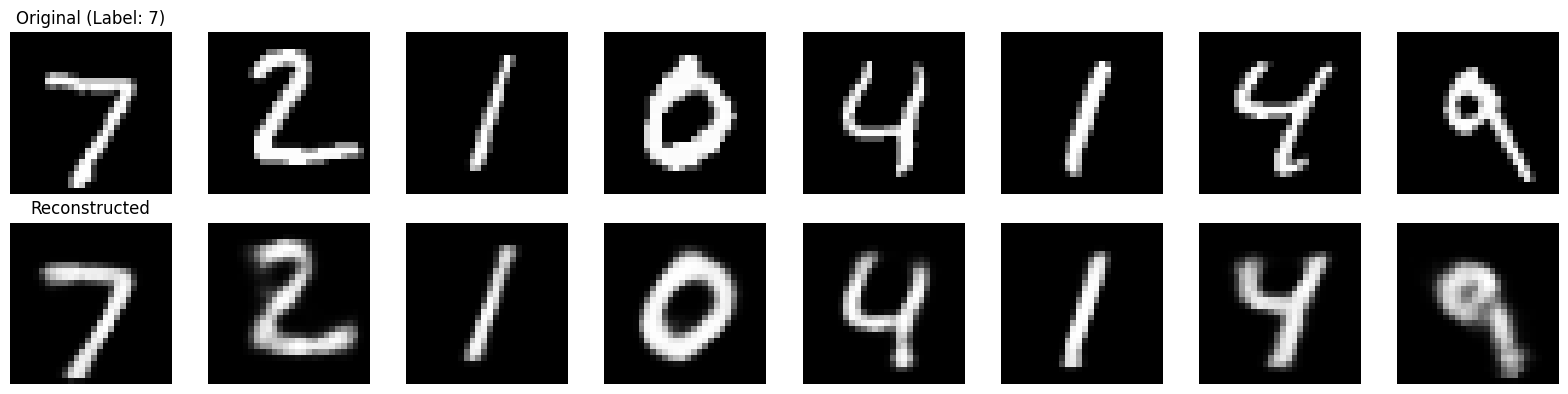

In [82]:
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor()
])

test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

visualize_conditional_reconstruction(model, test_loader, 'cpu', target_label=None, num_images=8)

In [ ]:
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor()
])

test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

visualize_reconstruction(model, test_loader, 'cpu')

# Conv Autoencoder


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

class ConditionalVAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20, condition_dim=10):
        super(ConditionalVAE, self).__init__()
        
        self.condition_dim = condition_dim
        self.input_with_condition = input_dim + condition_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(self.input_with_condition, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
        # Mean and variance layers
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + condition_dim, hidden_dim),  # Note: decoder input includes condition
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )
        
    def encode(self, x, c):
        # Concatenate input and condition
        x_c = torch.cat([x, c], dim=1)
        h = self.encoder(x_c)
        return self.fc_mu(h), self.fc_var(h)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z, c):
        # Concatenate latent vector and condition
        z_c = torch.cat([z, c], dim=1)
        return self.decoder(z_c)
    
    def forward(self, x, c):
        mu, log_var = self.encode(x.view(-1, 784), c)
        z = self.reparameterize(mu, log_var)
        return self.decode(z, c), mu, log_var

def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

def train_conditional_vae(model, train_loader, optimizer, device, epoch):
    model.train()
    train_loss = 0
    
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        
        # Convert labels to one-hot encoding
        c = F.one_hot(labels, num_classes=model.condition_dim).float().to(device)
        
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(data, c)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
    
    avg_loss = train_loss / len(train_loader.dataset)
    print(f'====> Epoch: {epoch} Average loss: {avg_loss:.4f}')
    return avg_loss

def visualize_conditional_reconstruction(model, data_loader, device, target_label=None, num_images=8):
    model.eval()
    with torch.no_grad():
        # Get a batch of images
        for data, labels in data_loader:
            if target_label is not None:
                # Filter images of target label
                mask = labels == target_label
                if mask.sum() >= num_images:
                    data = data[mask][:num_images]
                    labels = labels[mask][:num_images]
                    break
            else:
                data = data[:num_images]
                labels = labels[:num_images]
                break
        
        data = data.to(device)
        c = F.one_hot(labels, num_classes=model.condition_dim).float().to(device)
        
        # Get reconstructions
        recon_batch, _, _ = model(data, c)
        
        # Plot original and reconstructed images
        fig, axes = plt.subplots(2, num_images, figsize=(2*num_images, 4))
        
        for i in range(num_images):
            # Original images
            axes[0, i].imshow(data[i].cpu().numpy().reshape(28, 28), cmap='gray')
            axes[0, i].axis('off')
            if i == 0:
                axes[0, i].set_title(f'Original (Label: {labels[i].item()})')
            
            # Reconstructed images
            axes[1, i].imshow(recon_batch[i].cpu().numpy().reshape(28, 28), cmap='gray')
            axes[1, i].axis('off')
            if i == 0:
                axes[1, i].set_title('Reconstructed')
        
        plt.tight_layout()
        return fig

def generate_conditioned_samples(model, device, condition, num_samples=8):
    model.eval()
    with torch.no_grad():
        # Create one-hot encoded condition
        c = F.one_hot(torch.tensor([condition] * num_samples), 
                     num_classes=model.condition_dim).float().to(device)
        
        # Sample from latent space
        z = torch.randn(num_samples, model.fc_mu.out_features).to(device)
        
        # Generate samples
        samples = model.decode(z, c)
        
        # Visualize
        fig, axes = plt.subplots(1, num_samples, figsize=(2*num_samples, 2))
        for i in range(num_samples):
            axes[i].imshow(samples[i].cpu().numpy().reshape(28, 28), cmap='gray')
            axes[i].axis('off')
            if i == 0:
                axes[i].set_title(f'Generated (Label: {condition})')
        
        plt.tight_layout()
        return fig

def main():
    # Hyperparameters
    batch_size = 128
    epochs = 5
    learning_rate = 1e-3
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load MNIST dataset
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize model, optimizer
    model = ConditionalVAE(condition_dim=10).to(device)  # 10 classes for MNIST
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training loop
    for epoch in range(1, epochs + 1):
        loss = train_conditional_vae(model, train_loader, optimizer, device, epoch)
        
        # Visualize reconstructions every 10 epochs
        if epoch % 10 == 0:
            # Visualize general reconstructions
            fig1 = visualize_conditional_reconstruction(model, train_loader, device)
            plt.close(fig1)
            
            # Visualize generated samples for a specific digit
            fig2 = generate_conditioned_samples(model, device, condition=7)  # Generate digit 7
            plt.close(fig2)
    
    return model

if __name__ == "__main__":
    model = main()

Train Epoch: 1 [0/60000 (0%)]	Loss: 543.504517
Train Epoch: 1 [12800/60000 (21%)]	Loss: 198.536484
Train Epoch: 1 [25600/60000 (43%)]	Loss: 155.062271
Train Epoch: 1 [38400/60000 (64%)]	Loss: 145.275208
Train Epoch: 1 [51200/60000 (85%)]	Loss: 142.151550
====> Epoch: 1 Average loss: 167.7229
Train Epoch: 2 [0/60000 (0%)]	Loss: 129.791229
Train Epoch: 2 [12800/60000 (21%)]	Loss: 125.729263
Train Epoch: 2 [25600/60000 (43%)]	Loss: 123.110619
Train Epoch: 2 [38400/60000 (64%)]	Loss: 120.193649
Train Epoch: 2 [51200/60000 (85%)]	Loss: 117.099136
====> Epoch: 2 Average loss: 123.0143
Train Epoch: 3 [0/60000 (0%)]	Loss: 112.631104
Train Epoch: 3 [12800/60000 (21%)]	Loss: 115.049080
Train Epoch: 3 [25600/60000 (43%)]	Loss: 117.202835
Train Epoch: 3 [38400/60000 (64%)]	Loss: 116.039612
Train Epoch: 3 [51200/60000 (85%)]	Loss: 110.768692
====> Epoch: 3 Average loss: 113.7051
Train Epoch: 4 [0/60000 (0%)]	Loss: 106.070862
Train Epoch: 4 [12800/60000 (21%)]	Loss: 115.185242
Train Epoch: 4 [25600/

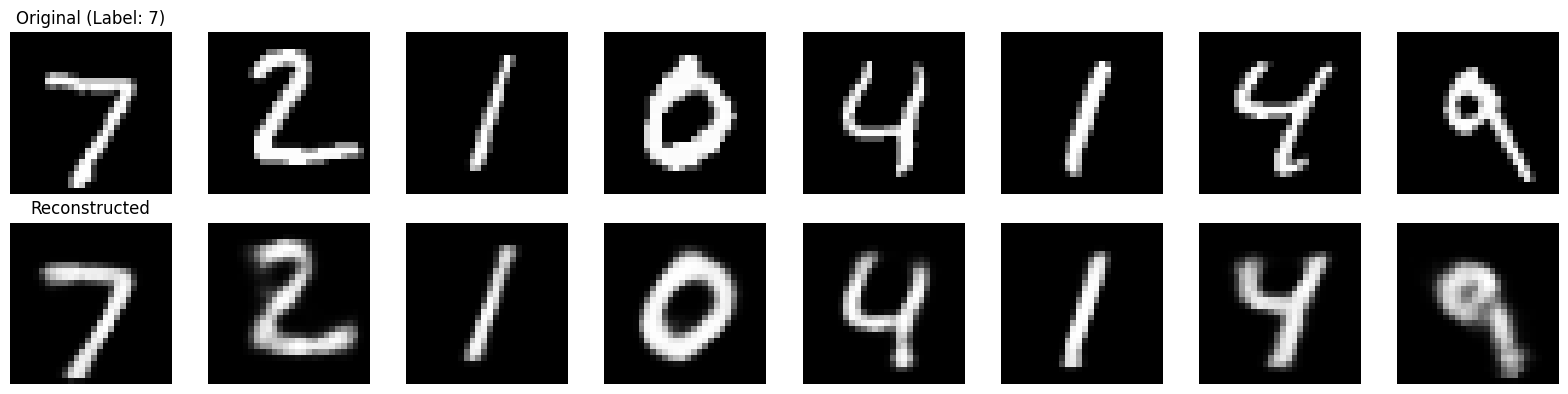

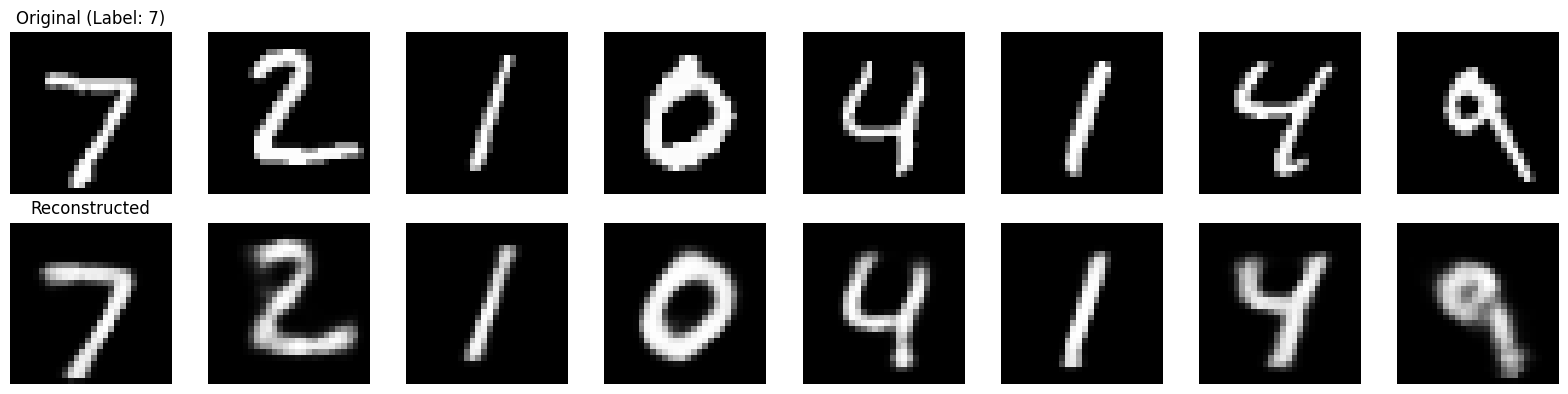

In [ ]:
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor()
])

test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

visualize_conditional_reconstruction(model, test_loader, 'cpu', target_label=None, num_images=8)

# cvae mnist

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define the CVAE class
class CVAE(nn.Module):
    def __init__(self, image_dim, state_dim, latent_dim):
        super(CVAE, self).__init__()
        self.image_dim = image_dim
        self.state_dim = state_dim
        self.latent_dim = latent_dim

        # Encoder: q(z | y, s)
        self.encoder = nn.Sequential(
            nn.Linear(image_dim + state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
        )
        self.mu_layer = nn.Linear(128, latent_dim)  # Mean of q(z | y, s)
        self.log_var_layer = nn.Linear(128, latent_dim)  # Log-variance of q(z | y, s)

        # Decoder: p(y | z, s)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, image_dim),
            nn.Sigmoid()  # Output probabilities for binary images (e.g., MNIST)
        )

    def encode(self, y, s):
        """
        Encodes the observation y and state s into a latent distribution q(z | y, s).
        """
        inputs = torch.cat([y, s], dim=1)
        h = self.encoder(inputs)
        mu = self.mu_layer(h)
        log_var = self.log_var_layer(h)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        """
        Reparameterization trick to sample from N(mu, sigma^2) using N(0, 1).
        """
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, s):
        """
        Decodes latent variable z and state s into an image.
        """
        inputs = torch.cat([z, s], dim=1)
        return self.decoder(inputs)

    def forward(self, y, s):
        """
        Forward pass through the CVAE: y -> q(z | y, s) -> z -> p(y | z, s).
        """
        mu, log_var = self.encode(y, s)
        z = self.reparameterize(mu, log_var)
        recon_y = self.decode(z, s)
        return recon_y, mu, log_var

    def compute_loss(self, y, recon_y, mu, log_var):
        """
        Computes the ELBO loss for training the CVAE.
        """
        recon_loss = F.binary_cross_entropy(recon_y, y, reduction='sum')  # Reconstruction loss
        kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())  # KL divergence
        return recon_loss + kl_divergence

# Training the CVAE on MNIST
def train_cvae():
    # Hyperparameters
    batch_size = 64
    epochs = 10
    learning_rate = 1e-3

    # Data loaders
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.view(-1))  # Flatten the image
    ])

    train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Model, optimizer, and loss
    image_dim = 28 * 28  # For MNIST images
    state_dim = 10  # Example state dimension (dummy states)
    latent_dim = 20
    cvae = CVAE(image_dim, state_dim, latent_dim)
    optimizer = torch.optim.Adam(cvae.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (images, _) in enumerate(train_loader):
            # Dummy state input (e.g., random noise for simplicity)
            batch_size = images.size(0)
            states = torch.rand(batch_size, state_dim)

            # Forward pass
            recon_images, mu, log_var = cvae(images, states)
            loss = cvae.compute_loss(images, recon_images, mu, log_var)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {total_loss / len(train_loader.dataset):.4f}")
    return cvae

# Run training
if __name__ == "__main__":
    cvae = train_cvae()


Epoch [1/10], Loss: 173.0020
Epoch [2/10], Loss: 128.7268
Epoch [3/10], Loss: 120.5883
Epoch [4/10], Loss: 116.7430
Epoch [5/10], Loss: 113.8662
Epoch [6/10], Loss: 111.8306
Epoch [7/10], Loss: 110.3375
Epoch [8/10], Loss: 109.1425
Epoch [9/10], Loss: 108.1146
Epoch [10/10], Loss: 107.3804


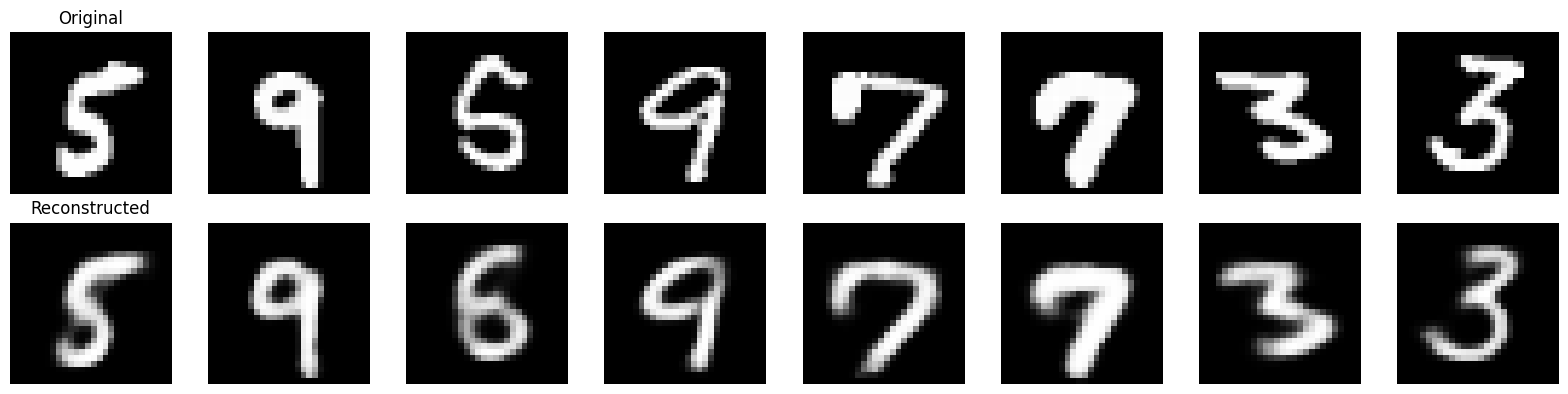

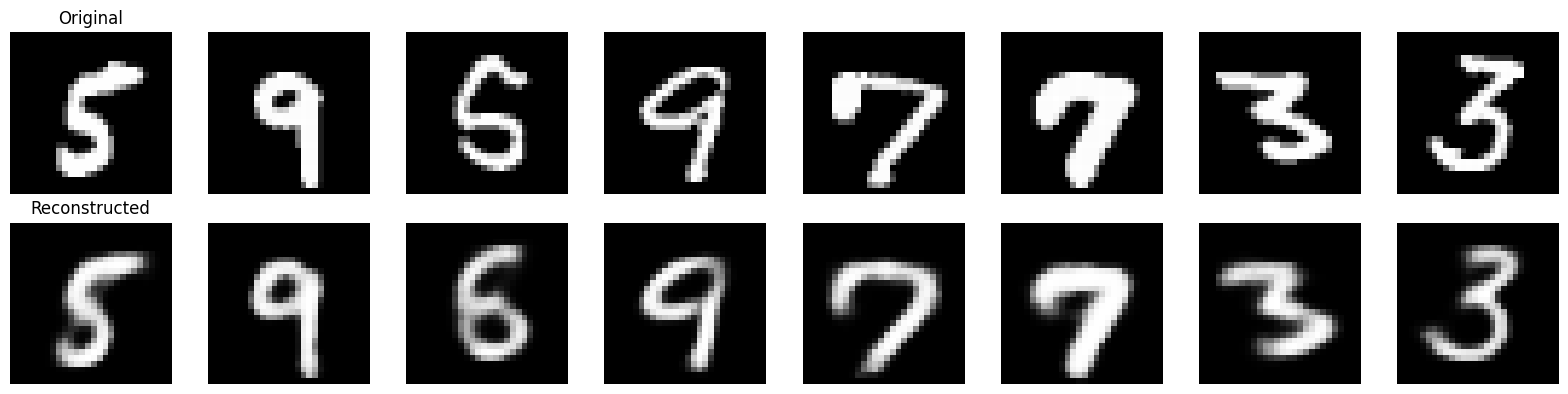

In [23]:
def cvae_visualize_reconstruction(model, data_loader, device, num_images=8):
    model.eval()
    with torch.no_grad():
        data = next(iter(data_loader))[0][:num_images].to(device)

        recon_batch, _, _ = model(data,torch.rand(8, 10).to(device))
        
        # Plot original and reconstructed images
        fig, axes = plt.subplots(2, num_images, figsize=(2*num_images, 4))
        
        for i in range(num_images):
            # Original images
            axes[0, i].imshow(data[i].cpu().numpy().reshape(28, 28), cmap='gray')
            axes[0, i].axis('off')
            if i == 0:
                axes[0, i].set_title('Original')
                
            # Reconstructed images
            axes[1, i].imshow(recon_batch[i].cpu().numpy().reshape(28, 28), cmap='gray')
            axes[1, i].axis('off')
            if i == 0:
                axes[1, i].set_title('Reconstructed')
        
        plt.tight_layout()
        return fig
    
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten the image
])

test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

cvae_visualize_reconstruction(cvae, test_loader, 'cpu')


tensor(-94.0791, grad_fn=<MeanBackward0>)

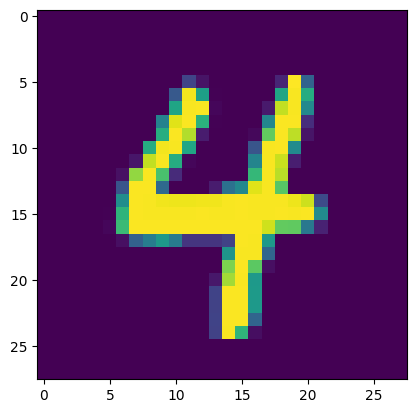

In [48]:
def evaluate_likelihood(cvae, y, s, num_samples=100):
    """
    Evaluates the likelihood p(y | s) using importance sampling.
    """
    mu, log_var = cvae.encode(y, s)
    std = torch.exp(0.5 * log_var)
    batch_size, latent_dim = mu.shape

    log_p_y_given_s = 0.0

    for _ in range(num_samples):
        z = cvae.reparameterize(mu, log_var)  # Sample z from q(z | y, s)
        recon_y = cvae.decode(z, s)  # Decode p(y | z, s)

        # Compute log-likelihood of y under the reconstruction
        log_p_y_given_z_s = -F.binary_cross_entropy(recon_y, y, reduction='none').sum(dim=1)

        # Compute log-likelihood of z under the prior
        log_p_z = -0.5 * (z.pow(2).sum(dim=1) + latent_dim * torch.log(torch.tensor(2 * torch.pi)))

        # Compute log-likelihood of z under the approximate posterior q(z | y, s)
        log_q_z_given_y_s = -0.5 * ((2 * std.log()).sum(dim=1) + ((z - mu).pow(2) / std.pow(2)).sum(dim=1) + latent_dim * torch.log(torch.tensor(2 * torch.pi)))

        # Combine terms for log-likelihood p(y | s)
        log_p_y_given_s += torch.exp(log_p_y_given_z_s + log_p_z - log_q_z_given_y_s)

    # Average over samples
    log_p_y_given_s = torch.log(log_p_y_given_s / num_samples)
    return log_p_y_given_s.mean()


# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten the image
])

test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

# sample a random image and state
images = next(iter(test_loader))[0]

import matplotlib.pyplot as plt
plt.imshow(images[0].view(28, 28).numpy())

batch_size = images.shape[0]
state_dim = 10
states = torch.rand(batch_size, state_dim)

# Evaluate likelihood on test data
evaluate_likelihood(cvae, images, states, num_samples=100)


# any deform


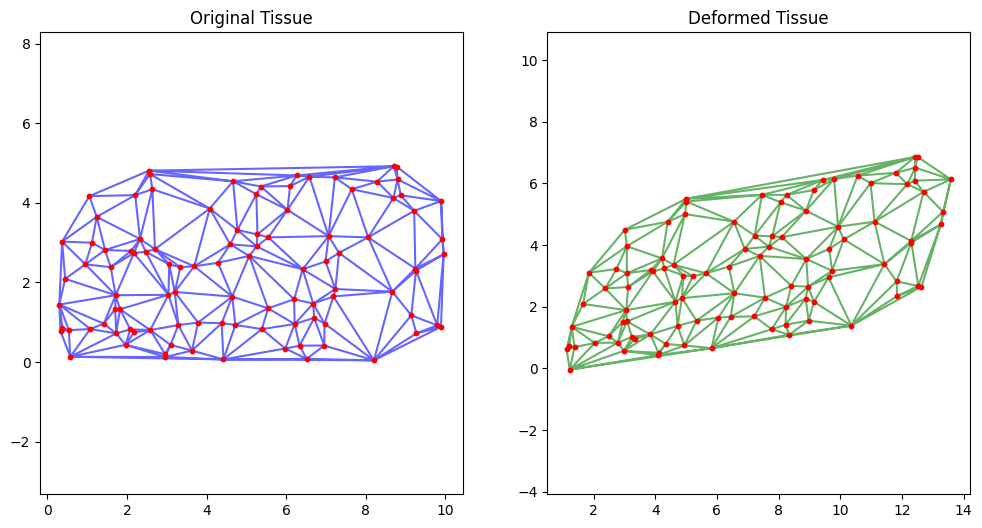

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay

# Define a function to generate a 2D elastic tissue mesh
def generate_tissue(width, height, n_points):
    """Generate a random 2D mesh of elastic tissue."""
    x = np.random.uniform(0, width, n_points)
    y = np.random.uniform(0, height, n_points)
    points = np.vstack((x, y)).T
    tri = Delaunay(points)
    return points, tri

# Define a function to apply deformation to the mesh
def deform_tissue(points, tri, deformation_function):
    """Deform the 2D mesh based on a user-defined deformation function.

    Args:
        points (ndarray): Array of shape (n_points, 2) with x, y coordinates.
        tri (Delaunay): Triangulation of the points.
        deformation_function (callable): Function that maps (x, y) -> (x', y').

    Returns:
        deformed_points (ndarray): Array of deformed points.
    """
    deformed_points = np.array([deformation_function(p[0], p[1]) for p in points])
    return deformed_points

# Define a sample deformation function (e.g., stretching)
def sample_deformation(x, y):
    """Example deformation function: apply an affine transformation."""
    # Define an affine transformation matrix
    A = np.array([[1.2, 0.3],  # Stretch and shear in x
                  [0.2, 1.1]])  # Shear and stretch in y
    b = np.array([0.5, -0.3])  # Translation vector

    # Apply the transformation
    original_point = np.array([x, y])
    transformed_point = A @ original_point + b
    return transformed_point[0], transformed_point[1]

# Visualization of the tissue before and after deformation
def visualize_tissue(points, tri, deformed_points):
    """Visualize the tissue mesh before and after deformation."""
    plt.figure(figsize=(12, 6))

    # Original tissue
    plt.subplot(1, 2, 1)
    plt.triplot(points[:, 0], points[:, 1], tri.simplices, color='blue', alpha=0.6)
    plt.scatter(points[:, 0], points[:, 1], color='red', s=10)
    plt.title("Original Tissue")
    plt.axis("equal")

    # Deformed tissue
    plt.subplot(1, 2, 2)
    plt.triplot(deformed_points[:, 0], deformed_points[:, 1], tri.simplices, color='green', alpha=0.6)
    plt.scatter(deformed_points[:, 0], deformed_points[:, 1], color='red', s=10)
    plt.title("Deformed Tissue")
    plt.axis("equal")

    plt.show()

# Main workflow
if __name__ == "__main__":
    # Generate a 2D elastic tissue
    width, height = 10, 5
    n_points = 100
    points, tri = generate_tissue(width, height, n_points)

    # Apply deformation
    deformed_points = deform_tissue(points, tri, sample_deformation)

    # Visualize the results
    visualize_tissue(points, tri, deformed_points)


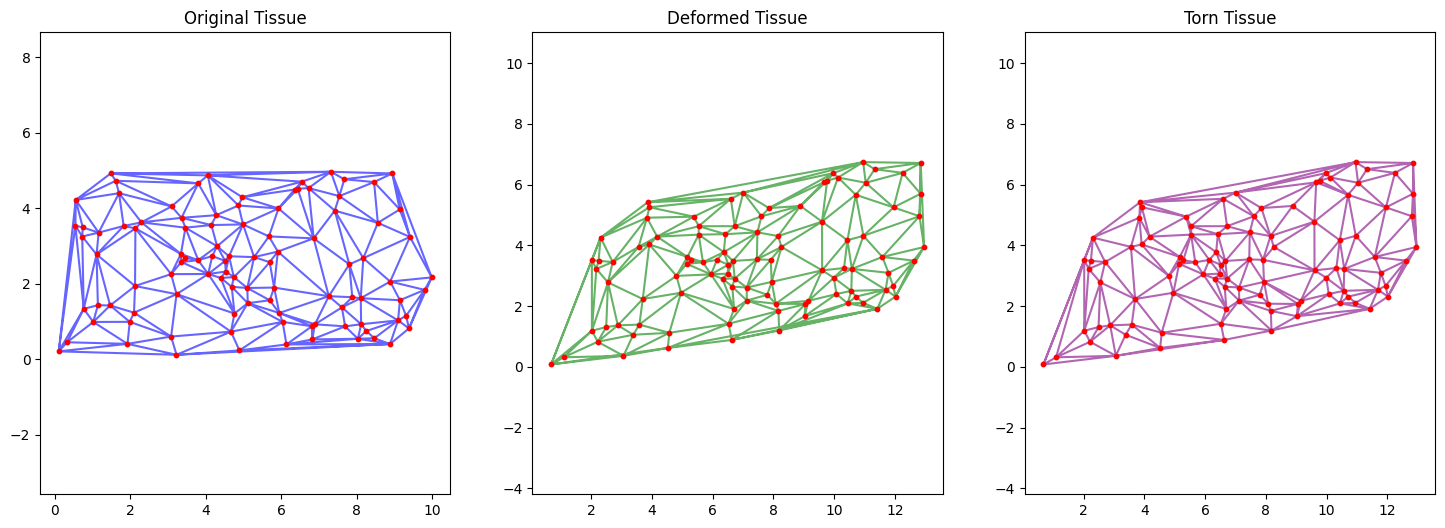

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay

# Define a function to generate a 2D elastic tissue mesh
def generate_tissue(width, height, n_points):
    """Generate a random 2D mesh of elastic tissue."""
    x = np.random.uniform(0, width, n_points)
    y = np.random.uniform(0, height, n_points)
    points = np.vstack((x, y)).T
    tri = Delaunay(points)
    return points, tri

# Define a function to apply deformation to the mesh
def deform_tissue(points, tri, deformation_function):
    """Deform the 2D mesh based on a user-defined deformation function.

    Args:
        points (ndarray): Array of shape (n_points, 2) with x, y coordinates.
        tri (Delaunay): Triangulation of the points.
        deformation_function (callable): Function that maps (x, y) -> (x', y').

    Returns:
        deformed_points (ndarray): Array of deformed points.
    """
    deformed_points = np.array([deformation_function(p[0], p[1]) for p in points])
    return deformed_points

# Define a sample deformation function (e.g., general affine and nonlinear transformations)
def sample_deformation(x, y):
    """Example deformation function: apply both affine and nonlinear transformations."""
    # Affine transformation
    A = np.array([[1.2, 0.3],  # Stretch and shear in x
                  [0.2, 1.1]])  # Shear and stretch in y
    b = np.array([0.5, -0.3])  # Translation vector

    original_point = np.array([x, y])
    affine_transformed = A @ original_point + b

    # Nonlinear deformation (e.g., sinusoidal warping)
    nonlinear_x = affine_transformed[0] + 0.2 * np.sin(2 * np.pi * affine_transformed[1] / 5)
    nonlinear_y = affine_transformed[1] + 0.2 * np.cos(2 * np.pi * affine_transformed[0] / 5)

    return nonlinear_x, nonlinear_y

# Define a function to simulate tearing
def simulate_tearing(points, tri, threshold=1.5):
    """Simulate tearing by removing edges that exceed a deformation threshold.

    Args:
        points (ndarray): Array of original points.
        tri (Delaunay): Triangulation of the points.
        threshold (float): Maximum allowable distance for an edge before tearing occurs.

    Returns:
        new_tri (Delaunay): Updated triangulation after tearing.
    """
    edges = []
    for simplex in tri.simplices:
        for i in range(3):
            p1, p2 = points[simplex[i]], points[simplex[(i + 1) % 3]]
            if np.linalg.norm(p1 - p2) <= threshold:
                edges.append((simplex[i], simplex[(i + 1) % 3]))

    # Create a new triangulation from the remaining edges
    unique_edges = np.unique(edges)
    new_points = points[unique_edges]
    new_tri = Delaunay(new_points)
    return new_points, new_tri

# Visualization of the tissue before and after deformation/tearing
def visualize_tissue(points, tri, deformed_points, torn_points=None, torn_tri=None):
    """Visualize the tissue mesh before and after deformation or tearing."""
    plt.figure(figsize=(18, 6))

    # Original tissue
    plt.subplot(1, 3, 1)
    plt.triplot(points[:, 0], points[:, 1], tri.simplices, color='blue', alpha=0.6)
    plt.scatter(points[:, 0], points[:, 1], color='red', s=10)
    plt.title("Original Tissue")
    plt.axis("equal")

    # Deformed tissue
    plt.subplot(1, 3, 2)
    plt.triplot(deformed_points[:, 0], deformed_points[:, 1], tri.simplices, color='green', alpha=0.6)
    plt.scatter(deformed_points[:, 0], deformed_points[:, 1], color='red', s=10)
    plt.title("Deformed Tissue")
    plt.axis("equal")

    # Torn tissue
    if torn_points is not None and torn_tri is not None:
        plt.subplot(1, 3, 3)
        plt.triplot(torn_points[:, 0], torn_points[:, 1], torn_tri.simplices, color='purple', alpha=0.6)
        plt.scatter(torn_points[:, 0], torn_points[:, 1], color='red', s=10)
        plt.title("Torn Tissue")
        plt.axis("equal")

    plt.show()

# Main workflow
if __name__ == "__main__":
    # Generate a 2D elastic tissue
    width, height = 10, 5
    n_points = 100
    points, tri = generate_tissue(width, height, n_points)

    # Apply deformation
    deformed_points = deform_tissue(points, tri, sample_deformation)

    # Simulate tearing
    torn_points, torn_tri = simulate_tearing(deformed_points, tri)

    # Visualize the results
    visualize_tissue(points, tri, deformed_points, torn_points, torn_tri)


In [ ]:
np.all(deformed_points == torn_points)

True

In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

# Define the PixelCNN class
class PixelCNN(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_channels=64):
        super(PixelCNN, self).__init__()

        self.input_dim = input_dim
        self.num_classes = num_classes

        # Gated convolutional layers
        self.conv1 = nn.Conv2d(num_classes, hidden_channels, kernel_size=7, padding=3)
        self.conv2 = nn.Conv2d(hidden_channels, hidden_channels, kernel_size=7, padding=3)
        self.conv3 = nn.Conv2d(hidden_channels, hidden_channels, kernel_size=7, padding=3)
        self.conv4 = nn.Conv2d(hidden_channels, num_classes, kernel_size=1)  # Final output layer

    def forward(self, x):
        """
        Forward pass through the PixelCNN model.
        """
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.conv4(x)  # Output logits for each pixel
        return x

# Helper to one-hot encode the input
def one_hot_encode(images, num_classes):
    batch_size, height, width = images.size()
    one_hot = torch.zeros(batch_size, num_classes, height, width, device=images.device)
    one_hot.scatter_(1, images.unsqueeze(1), 1)
    return one_hot

# Training the PixelCNN on MNIST
def train_pixelcnn():
    # Hyperparameters
    batch_size = 64
    epochs = 10
    learning_rate = 1e-3
    num_classes = 256  # Pixel intensity levels

    # Data loaders
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: (x * 255).long())  # Scale to [0, 255] and convert to int
    ])

    train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Model, optimizer, and loss
    input_dim = (28, 28)  # MNIST image dimensions
    pixelcnn = PixelCNN(input_dim, num_classes).to(device)
    optimizer = torch.optim.Adam(pixelcnn.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (images, _) in tqdm(enumerate(train_loader),total=len(train_loader)):
            images = images.squeeze(1)  # Remove channel dimension
            one_hot_images = one_hot_encode(images, num_classes)

            # Forward pass
            logits = pixelcnn(one_hot_images.to(device))

            # Compute loss (cross-entropy)
            loss = F.cross_entropy(logits, images)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {total_loss / len(train_loader.dataset):.4f}")

    return pixelcnn
# Computing likelihood of an observation
def compute_likelihood(pixelcnn, image):
    """
    Computes the likelihood of an image under the trained PixelCNN model.
    """
    image = image.unsqueeze(0).long()  # Add batch dimension and convert to int
    one_hot_image = one_hot_encode(image, pixelcnn.num_classes)

    with torch.no_grad():
        logits = pixelcnn(one_hot_image)
        probs = F.softmax(logits, dim=1)

    # Compute likelihood as the product of probabilities
    likelihood = torch.gather(probs, 1, image.unsqueeze(1)).squeeze(1)
    log_likelihood = likelihood.log().sum()

    return log_likelihood.item()

# Run training
if __name__ == "__main__":
    pixelcnn = train_pixelcnn()


RuntimeError: CUDA error: CUDA-capable device(s) is/are busy or unavailable
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


# cvae tissue manipulation

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

class ConditionalVAEold(nn.Module):
    def __init__(self, latent_dim=128, condition_dim=4):
        super(ConditionalVAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        
        # Calculate the size of flattened features
        self.flatten_size = 512 * 16 * 32
        
        # Condition embedding
        self.condition_encoder = nn.Sequential(
            nn.Linear(condition_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU()
        )
        
        # Mu and logvar layers
        self.fc_mu = nn.Linear(self.flatten_size + 1024, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_size + 1024, latent_dim)
        
        # Decoder input
        self.decoder_input = nn.Linear(latent_dim + condition_dim, self.flatten_size)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )
        
    def encode(self, x, c):
        # Encode the input image
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten
        
        # Encode the condition
        c = self.condition_encoder(c)
        
        # Concatenate image features and condition
        x = torch.cat([x, c], dim=1)
        
        # Get mu and logvar
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z, c):
        # Concatenate latent vector and condition
        z = torch.cat([z, c], dim=1)
        
        # Pass through decoder input layer
        x = self.decoder_input(z)
        
        # Reshape to match decoder input dimensions
        x = x.view(x.size(0), 512, 16, 32)
        
        # Decode
        x = self.decoder(x)
        return x
    
    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, c), mu, logvar

class ConditionalVAE(nn.Module):
    def __init__(self, latent_dim=128, condition_dim=4):
        super(ConditionalVAE, self).__init__()
        
        # Further reduced number of filters in encoder (approximately 1/4)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        
        # Reduced flatten size
        self.flatten_size = 128 * 16 * 32
        
        # Further simplified condition encoder
        self.condition_encoder = nn.Sequential(
            nn.Linear(condition_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU()
        )
        
        # Reduced dimensions for mu and logvar layers
        self.fc_mu = nn.Linear(self.flatten_size + 256, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_size + 256, latent_dim)
        
        # Decoder input with reduced dimensions
        self.decoder_input = nn.Linear(latent_dim + condition_dim, self.flatten_size)
        
        # Decoder with further reduced number of filters
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )
    
    def encode(self, x, c):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        c = self.condition_encoder(c)
        x = torch.cat([x, c], dim=1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z, c):
        z = torch.cat([z, c], dim=1)
        x = self.decoder_input(z)
        x = x.view(x.size(0), 128, 16, 32)
        x = self.decoder(x)
        return x
    
    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, c), mu, logvar

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    """
    Calculate the VAE loss with KL divergence
    """
    # Reconstruction loss (binary cross entropy)
    # BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    MSE = F.mse_loss(recon_x, x, reduction='sum')

    # KL divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return MSE + beta * KLD, MSE, KLD

def train_cvae():
    # Hyperparameters
    batch_size = 20
    epochs = 1
    learning_rate = 1e-3
    limit = -1
    wandb = False
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if torch.cuda.is_available():
        print(f"Training on {torch.cuda.get_device_name(0)}")
        # clear memory
        torch.cuda.empty_cache()
        torch.cuda.reset_accumulated_memory_stats()    

    if wandb:
        import wandb
        wandb.init(project="conditional-vae")


    import numpy as np
    images = np.load('dataset/images.npy')
    actions = np.load('dataset/actions.npy')

    from torch.utils.data import Dataset, DataLoader
    class CustomDataset(Dataset):
        def __init__(self, images, actions, transforms=None):
            """
            Args:
                data_list (list): List of dictionaries containing 'o', 'theta', 'qpos', and 'qpos_new'.
            """
            assert len(images) == len(actions), "Number of images and actions must match."

            self.observations = images
            self.latent = actions
            self.transforms = transforms

        def __len__(self):
            """Returns the total number of samples."""
            return len(self.observations)

        def __getitem__(self, idx):
            """
            Retrieve one sample of data by index.

            Args:
                idx (int): Index of the sample to retrieve.

            Returns:
                A dictionary with inputs and expected outputs as tensors.
            """
            # Extract the dictionary for the given index
            image = self.observations[idx]
            action = self.latent[idx]
            
            # Convert data to PyTorch tensors
            theta = torch.tensor(action, dtype=torch.float32)
            o = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1) / 255.0
            # pos = è costante in questo caso      

            # Inputs: qpos_new, o, theta
            inputs = {
                'theta': theta,
                'deform_obs': o    
            }
            
            # Output: qpos_new
            target = {
                'theta': theta,
                'deform_obs': o    
            }
            
            return inputs, target

    # Instantiate the dataset
    custom_dataset = CustomDataset(images[:limit], actions[:limit])

    # Create a DataLoader
    train_loader = DataLoader(custom_dataset, batch_size, shuffle=True)

    # Model, optimizer, and loss
    model = ConditionalVAE()
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    from tqdm.notebook import tqdm    # Training loop
    print("------TRAINING STARTED-----")
    print(f"Model has {count_parameters(model):,} trainable parameters")
    print(f"Training on {device}")
    print(f"len Dataset: {len(custom_dataset)}")

    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (images, _) in tqdm(enumerate(train_loader), total=len(train_loader)):
            optimizer.zero_grad()

            recon_images, mu, log_var = model(images['deform_obs'].to(device), images['theta'].to(device))
            loss = vae_loss(recon_images, images['deform_obs'].to(device), mu, log_var)

            # Backward pass
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            running_loss = total_loss / (batch_idx + 1)

        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {total_loss / (len(train_loader)):.4f}")
        if wandb:
            wandb.log({"loss": total_loss / len(train_loader)})
    
    return model

# Run training
if __name__ == "__main__":
    model = train_cvae()


Training on NVIDIA GeForce GTX 1650 Ti


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConditionalVAE(nn.Module):
    def __init__(self, latent_dim=128, condition_dim=4):
        super(ConditionalVAE, self).__init__()
        
        # Further reduced number of filters in encoder (approximately 1/4)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        
        # Reduced flatten size
        self.flatten_size = 128 * 16 * 32
        
        # Further simplified condition encoder
        self.condition_encoder = nn.Sequential(
            nn.Linear(condition_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU()
        )
        
        # Reduced dimensions for mu and logvar layers
        self.fc_mu = nn.Linear(self.flatten_size + 256, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_size + 256, latent_dim)
        
        # Decoder input with reduced dimensions
        self.decoder_input = nn.Linear(latent_dim + condition_dim, self.flatten_size)
        
        # Decoder with further reduced number of filters
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )
    
    def encode(self, x, c):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        c = self.condition_encoder(c)
        x = torch.cat([x, c], dim=1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z, c):
        z = torch.cat([z, c], dim=1)
        x = self.decoder_input(z)
        x = x.view(x.size(0), 128, 16, 32)
        x = self.decoder(x)
        return x
    
    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, c), mu, logvar

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    """
    Calculate the VAE loss with KL divergence
    """
    # Reconstruction loss (binary cross entropy)
    # BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    MSE = F.mse_loss(recon_x, x, reduction='sum')

    # KL divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    beta_warmup = min(1.0, epoch / 10) * beta 

    return MSE + beta_warmup * KLD, MSE, KLD

# Hyperparameters
batch_size = 8
epochs = 2
learning_rate = 1e-3
limit = -1
save_interval = 2
wandb = False
save_dir = 'checkpoints'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(f"Training on {torch.cuda.get_device_name(0)}")
    # clear memory
    torch.cuda.empty_cache()
    torch.cuda.reset_accumulated_memory_stats()    

if wandb:
    import wandb
    wandb.init(project="conditional-vae")


import numpy as np
images = np.load('dataset/images.npy')
actions = np.load('dataset/actions.npy')

from torch.utils.data import Dataset, DataLoader
class CustomDataset(Dataset):
    def __init__(self, images, actions, transforms=None):
        """
        Args:
            data_list (list): List of dictionaries containing 'o', 'theta', 'qpos', and 'qpos_new'.
        """
        assert len(images) == len(actions), "Number of images and actions must match."

        self.observations = images
        self.latent = actions
        self.transforms = transforms

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.observations)

    def __getitem__(self, idx):
        """
        Retrieve one sample of data by index.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            A dictionary with inputs and expected outputs as tensors.
        """
        # Extract the dictionary for the given index
        image = self.observations[idx]
        action = self.latent[idx]
        
        # Convert data to PyTorch tensors
        theta = torch.tensor(action, dtype=torch.float32)
        o = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1) / 255.0
        # pos = è costante in questo caso      

        # Inputs: qpos_new, o, theta
        inputs = {
            'theta': theta,
            'deform_obs': o    
        }
        
        # Output: qpos_new
        target = {
            'theta': theta,
            'deform_obs': o    
        }
        
        return inputs, target

# Instantiate the dataset
custom_dataset = CustomDataset(images[:limit], actions[:limit])

# Create a DataLoader
train_loader = DataLoader(custom_dataset, batch_size, shuffle=True)

# Model, optimizer, and loss
model = ConditionalVAE()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

from tqdm.notebook import tqdm    # Training loop
print("------TRAINING STARTED-----")
print(f"Model has {count_parameters(model):,} trainable parameters")
print(f"Training on {device}")
print(f"len Dataset: {len(custom_dataset)}")

for epoch in range(epochs):
    total_loss = 0
    total_recon = 0
    total_kl = 0
    
    # Progress bar
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
    
    for batch_idx, (data,_) in enumerate(pbar):
        # Move data to device
        condition = data['theta'].to(device)
        obs = data['deform_obs'].to(device)
        
        
        # Reset gradients
        optimizer.zero_grad()
        
        # Forward pass
        recon_batch, mu, logvar = model(obs, condition)
        
        # Compute loss
        loss, recon, kl = vae_loss(recon_batch, obs, mu, logvar)
        
        # Backward pass
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        # Update metrics
        total_loss += loss.item()
        total_recon += recon.item()
        total_kl += kl.item()
        
        # Update progress bar
        pbar.set_postfix({
            'loss': total_loss / (batch_idx + 1),
            'recon': total_recon / (batch_idx + 1),
            'kl': total_kl / (batch_idx + 1)
        })
    
    # Save model and generate samples at intervals
    if (epoch + 1) % save_interval == 0:
        # Save model checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': total_loss,
        }, f'{save_dir}/checkpoint_epoch_{epoch+1}.pt')
        
        # Generate and save sample reconstructions
        with torch.no_grad():
            # Get a batch of data
            sample_data, _  = next(iter(train_loader))
            obs = sample_data['deform_obs'].to(device)
            sample_condition = sample_data['theta'].to(device)
            
            # Generate reconstructions
            recon_data, _, _ = model(obs, sample_condition)
            
            # Save original and reconstructed images
            comparison = torch.cat([obs[:8], recon_data[:8]])
            # save_image(comparison.cpu(),
            #             f'{save_dir}/reconstruction_epoch_{epoch+1}.png',
            #             nrow=8)
            
            # Generate random samples
            random_z = torch.randn(8, model.fc_mu.out_features).to(device)
            random_samples = model.decode(random_z, sample_condition[:8])
            # save_image(random_samples.cpu(),
            #             f'{save_dir}/samples_epoch_{epoch+1}.png',
            #             nrow=8)
    
    # Print epoch summary
    print(f'Epoch {epoch+1}/{epochs}:')
    print(f'Average Loss: {total_loss / len(train_loader):.4f}')
    print(f'Average Reconstruction Loss: {total_recon / len(train_loader):.4f}')
    print(f'Average KL Divergence: {total_kl / len(train_loader):.4f}')


Training on NVIDIA GeForce GTX 1650 Ti


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [8]:
image, target = images[np.random.randint(len(images))], actions[np.random.randint(len(images))]
image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1) /255.0
target = torch.tensor(target, dtype=torch.float32)

with torch.no_grad():
    recon_image, _, _ = model(image.unsqueeze(0).to('cuda'), target.unsqueeze(0).to('cuda'))


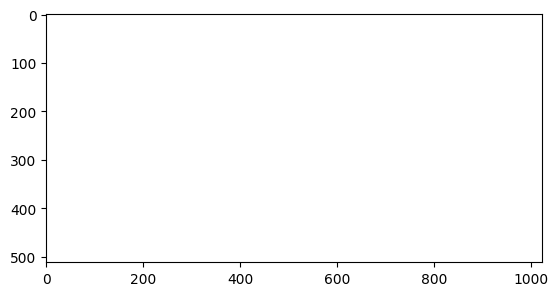

In [9]:
import matplotlib.pyplot as plt 
plt.imshow(recon_image.squeeze().cpu().permute(1, 2, 0))

In [17]:
import numpy as np
images = np.load('../../train/dataset/images.npy')
actions = np.load('dataset/actions.npy')
len(images), len(actions)

(2397, 2397)

In [115]:
actions

array([[ -25.263973 , -127.50631  ,  -35.218773 ,  -45.953648 ],
       [ -28.438747 ,  -36.41669  ,  -43.247055 ,  -35.6224   ],
       [ -32.59296  ,  -69.00562  ,    1.7277995, -120.29982  ],
       ...,
       [   6.31882  , -111.91385  ,   -8.749251 ,   -3.3304393],
       [  -9.17639  ,  -89.568504 ,  -26.698307 ,   -0.4754251],
       [  21.44207  ,  -15.944741 ,   10.362688 , -101.1833   ]],
      dtype=float32)

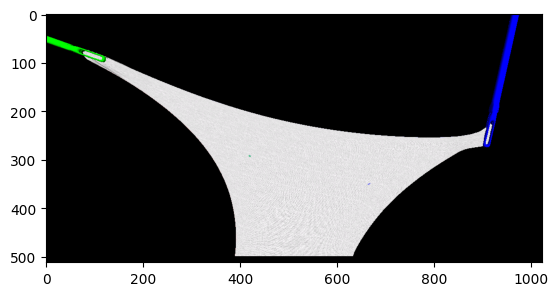

In [112]:
import matplotlib.pyplot as plt 
plt.imshow(images[np.random.randint(0, len(images))])

In [14]:
np.max(images[0]/255), np.min(images[0]/255)

(1.0, 0.0)

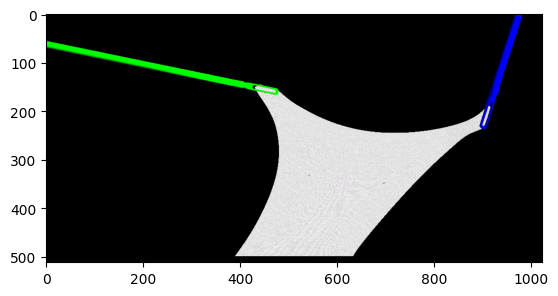

In [7]:
# convert images to normalized torch tensor
import torch
image = torch.tensor(images[0], dtype=torch.float32).permute(2,0,1) / 255.0

plt.imshow(image.permute(1,2,0))

In [17]:
import numpy as np
images = np.load('dataset/images_upto_2299.npy')
len(images)

300

In [13]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, images, actions):
        """
        Args:
            data_list (list): List of dictionaries containing 'o', 'theta', 'qpos', and 'qpos_new'.
        """
        assert len(images) == len(actions), "Number of images and actions must match."

        self.observations = images
        self.latent = actions

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.observations)

    def __getitem__(self, idx):
        """
        Retrieve one sample of data by index.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            A dictionary with inputs and expected outputs as tensors.
        """
        # Extract the dictionary for the given index
        image = self.observations[idx]
        action = self.latent[idx]
        
        # Convert data to PyTorch tensors
        theta = torch.tensor(action, dtype=torch.float32)
        o = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
        # pos = è costante in questo caso      
        

        # Inputs: qpos_new, o, theta
        inputs = {
            'theta': theta,
            'deform_obs': o    
        }
        
        # Output: qpos_new
        target = {
            'theta': theta,
            'deform_obs': o    
        }
        
        return inputs, target


# Instantiate the dataset
custom_dataset = CustomDataset(images, actions)

# Create a DataLoader
data_loader = DataLoader(custom_dataset, batch_size=10, shuffle=True)

# Visualize a batch of data
for inputs, targets in data_loader:
    print(f"Inputs: {inputs['deform_obs'].shape}, {inputs['theta'].shape}")
    print(f"Targets: {targets['deform_obs'].shape}, {targets['theta'].shape}")
    break

NameError: name 'images' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


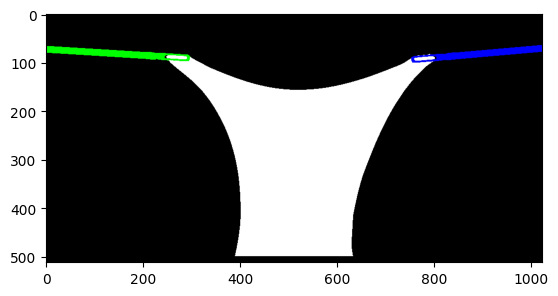

In [16]:
import matplotlib.pyplot as plt
plt.imshow(inputs['deform_obs'][0])

# eval

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConditionalVAE(nn.Module):
    def __init__(self, latent_dim=128, condition_dim=4):
        super(ConditionalVAE, self).__init__()
        
        # Further reduced number of filters in encoder (approximately 1/4)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        
        # Reduced flatten size
        self.flatten_size = 128 * 16 * 32
        
        # Further simplified condition encoder
        self.condition_encoder = nn.Sequential(
            nn.Linear(condition_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU()
        )
        
        # Reduced dimensions for mu and logvar layers
        self.fc_mu = nn.Linear(self.flatten_size + 256, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_size + 256, latent_dim)
        
        # Decoder input with reduced dimensions
        self.decoder_input = nn.Linear(latent_dim + condition_dim, self.flatten_size)
        
        # Decoder with further reduced number of filters
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )
    
    def encode(self, x, c):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        c = self.condition_encoder(c)
        x = torch.cat([x, c], dim=1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z, c):
        z = torch.cat([z, c], dim=1)
        x = self.decoder_input(z)
        x = x.view(x.size(0), 128, 16, 32)
        x = self.decoder(x)
        return x
    
    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, c), mu, logvar

model = ConditionalVAE()
model.load_state_dict(torch.load('checkpoint_epoch_40.ptrom')['model_state_dict'])

/tmp/ipykernel_12274/2234845929.py:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoint_epoch_40.ptrom')['model_state_dict'])


<All keys matched successfully>

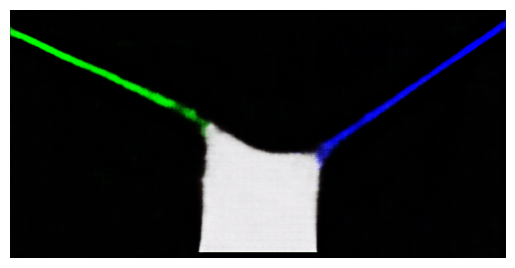

In [20]:
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, images, actions):
        """
        Args:
            data_list (list): List of dictionaries containing 'o', 'theta', 'qpos', and 'qpos_new'.
        """
        assert len(images) == len(actions), "Number of images and actions must match."

        self.observations = images
        self.latent = actions

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.observations)

    def __getitem__(self, idx):
        """
        Retrieve one sample of data by index.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            A dictionary with inputs and expected outputs as tensors.
        """
        # Extract the dictionary for the given index
        image = self.observations[idx]
        action = self.latent[idx]
        
        # Convert data to PyTorch tensors
        theta = torch.tensor(action, dtype=torch.float32)
        o = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
        # pos = è costante in questo caso      
        

        # Inputs: qpos_new, o, theta
        inputs = {
            'theta': theta,
            'deform_obs': o    
        }
        
        # Output: qpos_new
        target = {
            'theta': theta,
            'deform_obs': o    
        }
        
        return inputs, target

images = np.load('dataset/images.npy')
actions = np.load('dataset/actions.npy')

# Instantiate the dataset
custom_dataset = CustomDataset(images, actions)

# Create a DataLoader
data_loader = DataLoader(custom_dataset, batch_size=4, shuffle=True)

model.to('cuda')    
# Visualize a batch of data
for inputs, targets in data_loader:
    recon_image, _, _ = model(inputs['deform_obs'].to('cuda'), inputs['theta'].to('cuda'))

# Display the reconstructed image
plt.imshow(recon_image[0].detach().cpu().permute(1, 2, 0))
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


(-0.5, 1023.5, 511.5, -0.5)

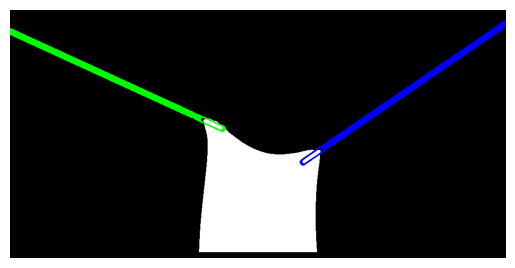

In [22]:
plt.imshow(inputs['deform_obs'][0].permute(1, 2, 0))
plt.axis('off')

/opt/conda/conda-bld/pytorch_1724789172399/work/aten/src/ATen/native/cuda/Loss.cu:95: operator(): block: [581,0,0], thread: [81,0,0] Assertion `target_val >= zero && target_val <= one` failed.
/opt/conda/conda-bld/pytorch_1724789172399/work/aten/src/ATen/native/cuda/Loss.cu:95: operator(): block: [652,0,0], thread: [102,0,0] Assertion `target_val >= zero && target_val <= one` failed.
/opt/conda/conda-bld/pytorch_1724789172399/work/aten/src/ATen/native/cuda/Loss.cu:95: operator(): block: [652,0,0], thread: [103,0,0] Assertion `target_val >= zero && target_val <= one` failed.
/opt/conda/conda-bld/pytorch_1724789172399/work/aten/src/ATen/native/cuda/Loss.cu:95: operator(): block: [652,0,0], thread: [106,0,0] Assertion `target_val >= zero && target_val <= one` failed.
/opt/conda/conda-bld/pytorch_1724789172399/work/aten/src/ATen/native/cuda/Loss.cu:95: operator(): block: [652,0,0], thread: [107,0,0] Assertion `target_val >= zero && target_val <= one` failed.
/opt/conda/conda-bld/pytorch_17

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


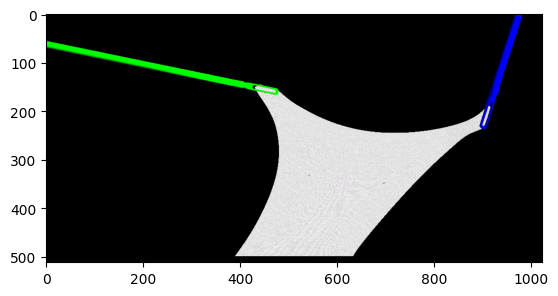

In [26]:
def evaluate_likelihood(cvae, y, s, num_samples=100):
    """
    Evaluates the likelihood p(y | s) using importance sampling.
    """
    mu, log_var = cvae.encode(y, s)
    std = torch.exp(0.5 * log_var)
    batch_size, latent_dim = mu.shape

    log_p_y_given_s = 0.0

    for _ in range(num_samples):
        z = cvae.reparameterize(mu, log_var)  # Sample z from q(z | y, s)
        recon_y = cvae.decode(z, s)  # Decode p(y | z, s)

        # Compute log-likelihood of y under the reconstruction
        log_p_y_given_z_s = -F.binary_cross_entropy(recon_y, y, reduction='none').sum(dim=1)

        # Compute log-likelihood of z under the prior
        log_p_z = -0.5 * (z.pow(2).sum(dim=1) + latent_dim * torch.log(torch.tensor(2 * torch.pi)))

        # Compute log-likelihood of z under the approximate posterior q(z | y, s)
        log_q_z_given_y_s = -0.5 * ((2 * std.log()).sum(dim=1) + ((z - mu).pow(2) / std.pow(2)).sum(dim=1) + latent_dim * torch.log(torch.tensor(2 * torch.pi)))

        # Combine terms for log-likelihood p(y | s)
        log_p_y_given_s += torch.exp(log_p_y_given_z_s + log_p_z - log_q_z_given_y_s)

    # Average over samples
    log_p_y_given_s = torch.log(log_p_y_given_s / num_samples)
    return log_p_y_given_s.mean()

# sample a random image and state
data = next(iter(data_loader))[0]

import matplotlib.pyplot as plt
plt.imshow(images[0])

batch_size = images.shape[0]

# Evaluate likelihood on test data
evaluate_likelihood(model, data['deform_obs'].to('cuda'), data['theta'].to('cuda'), num_samples=100)
